# Dispersion and its matching
We will show different technique to match the dispersion in a lattice. In an accelerator we need in some case insertions with zero dispersion (e.g., in the experimental IR to reduce the beam size, in the injection/extraction region, or for specific instruments or RF devices to decouple transverse and longitudinal properties).

## Dispersion waves and dispression suppressors
We will consider now the impact of few dipoles on the dispersion, more technically the dispersive response of a dipole in a transfer line (we are not imposing the periodicity of the solution).

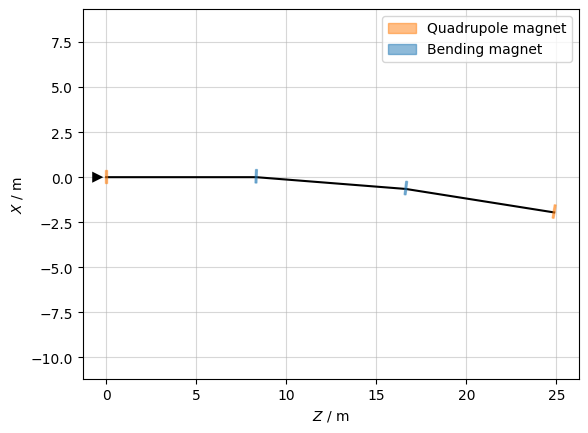

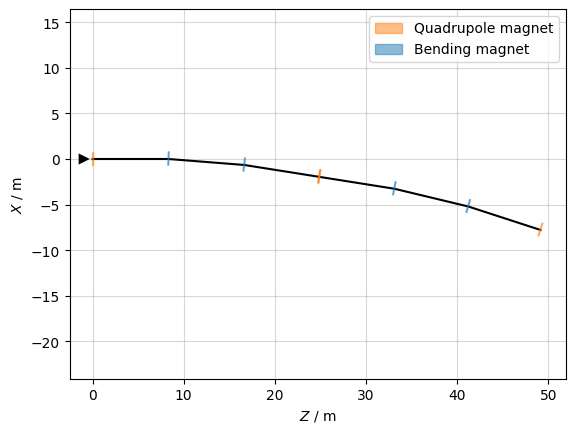

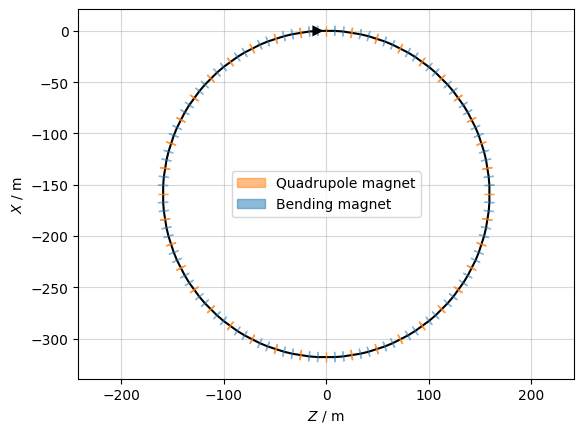

In [18]:
import xtrack as xt
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 



env = xt.Environment()
env.particle_ref = xt.Particles(p0c=1e12, mass0=xt.PROTON_MASS_EV)

circumference = 1000.0
number_of_cells = 20 #Number of cells 
cell_length = circumference/number_of_cells
number_of_dipole_per_cell = 4
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*number_of_cells);
env['k1'] = 0.0098

env.new('qf', xt.Multipole, knl = [0, 'k1/2'])
env.new('qd', xt.Multipole, knl = [0, '-k1/2'])
env.new('mb', xt.Multipole, knl = ['dipole_bending_angle'], hxl='dipole_bending_angle')


arc_half_cell = env.new_line(components=[
    env.place('qf'),
    env.place('mb', at=cell_length/6, from_='qf'),
    env.place('mb', at=cell_length*2/6, from_='qf'),
    env.place('qd', at=cell_length/2, from_='qf'),
    ])

arc_half_cell_straight = env.new_line(components=[
    env.place('qf'),
    env.place('qd', at=cell_length/2, from_='qf'),
    ])

arc_half_cell.survey().plot() # plots the layout of the created line
arc_half_cell.get_table()

arc_cell =  arc_half_cell - arc_half_cell
arc_cell.survey().plot() # plots the layout of the created line

cell_straight =  arc_half_cell_straight - arc_half_cell_straight

ring = number_of_cells * arc_cell 
ring.survey().plot()

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Matching 45 deg phase advance
opt = arc_cell.match(
    method='4d', # <- passed to twiss
    vary=[
        xt.Vary('k1', step=1e-8, tag='quad'),    ],
    targets = [
        xt.TargetSet(qx=1/8, tol=1e-6, tag='tune'),
    ])
opt.target_status()
k1_45deg = env['k1']

# Matching 60 deg phase advance
opt = arc_cell.match(
    method='4d', # <- passed to twiss
    vary=[
        xt.Vary('k1', step=1e-8, tag='quad'),    ],
    targets = [
        xt.TargetSet(qx=1/6, tol=1e-6, tag='tune'),
    ])
k1_60deg = env['k1']
opt.target_status()

# Matching 90 deg phase advance
opt = arc_cell.match(
    method='4d', # <- passed to twiss
    vary=[
        xt.Vary('k1', step=1e-8, tag='quad'),    ],
    targets = [
        xt.TargetSet(qx=1/4, tol=1e-6, tag='tune'),
    ])
opt.target_status()
k1_90deg = env['k1']

# Matching 135 deg phase advance
opt = arc_cell.match(
    method='4d', # <- passed to twiss
    vary=[
        xt.Vary('k1', step=1e-8, tag='quad'),    ],
    targets = [
        xt.TargetSet(qx=3/8, tol=1e-6, tag='tune'),
    ])
opt.target_status()
k1_135deg = env['k1']


env['k1'] = k1_60deg


Matching: model call n. 9               

Target status:                           
id state tag  tol_met       residue   current_val    target_val description                          
0  ON    tune    True   1.40555e-11         0.125         0.125 'qx', val=0.125, tol=1e-06, weight=10
Matching: model call n. 9               

Target status:                           
id state tag  tol_met       residue   current_val    target_val description                             
0  ON    tune    True   2.43613e-12      0.166667      0.166667 'qx', val=0.166667, tol=1e-06, weight=10
Matching: model call n. 9               

Target status:                           
id state tag  tol_met       residue   current_val    target_val description                         
0  ON    tune    True   2.59276e-08          0.25          0.25 'qx', val=0.25, tol=1e-06, weight=10
Matching: model call n. 15               

Target status:                           
id state tag  tol_met       residue   current_v

In [3]:
my_twiss = ring.twiss4d()
print(my_twiss.qx, my_twiss.qy)

3.333333333382056 3.3333333333820563


(0.0, 100.0)

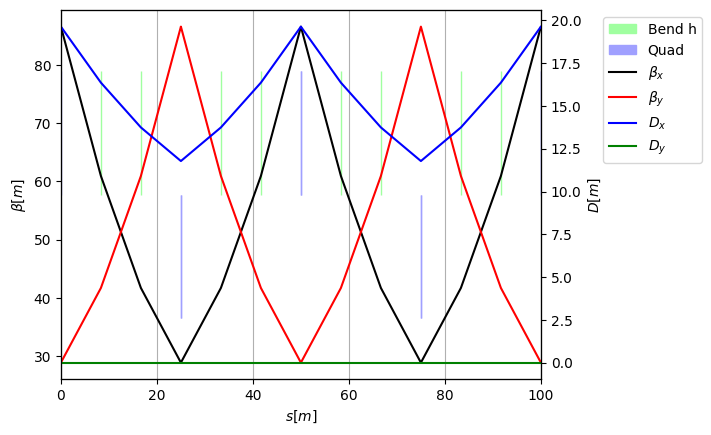

In [4]:
my_twiss.plot()
plt.xlim(0, 100)

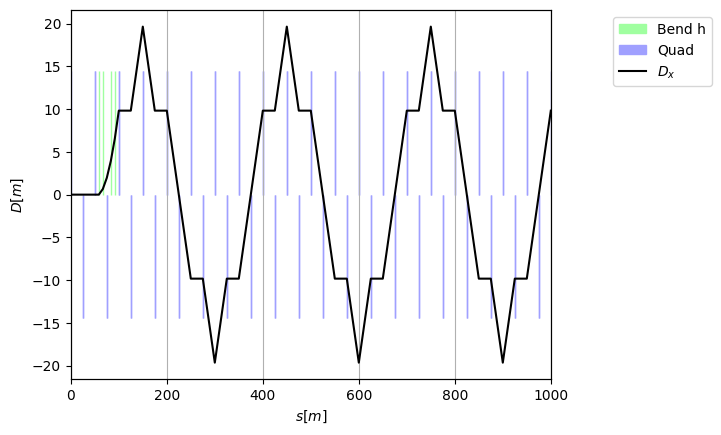

In [5]:
new_lattice = cell_straight+arc_cell+18*cell_straight
new_lattice.twiss4d(betx=my_twiss['betx'][0],
                    bety=my_twiss['bety'][0],
                    alfx=my_twiss['alfx'][0],
                    alfy=my_twiss['alfy'][0],
                    dx=0,
                    dpx=0).plot(yl='dx')

By traslating the FODO cell with the dipoles along the machine, as one expects, the dispersive wave move accordingly.

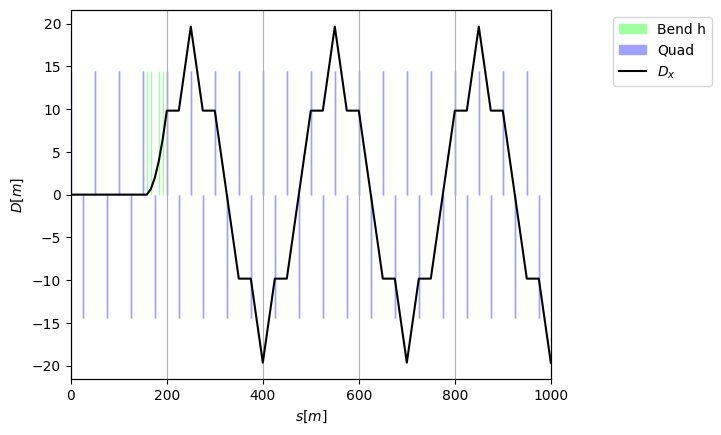

In [6]:
new_lattice = 3*cell_straight+arc_cell+16*cell_straight
new_lattice.twiss4d(betx=my_twiss['betx'][0],
                    bety=my_twiss['bety'][0],
                    alfx=my_twiss['alfx'][0],
                    alfy=my_twiss['alfy'][0],
                    dx=0,
                    dpx=0).plot(yl='dx')

Due to the linearity we can **sum-up the dispersive waves** and try to match it to the periodic dispersive functions.

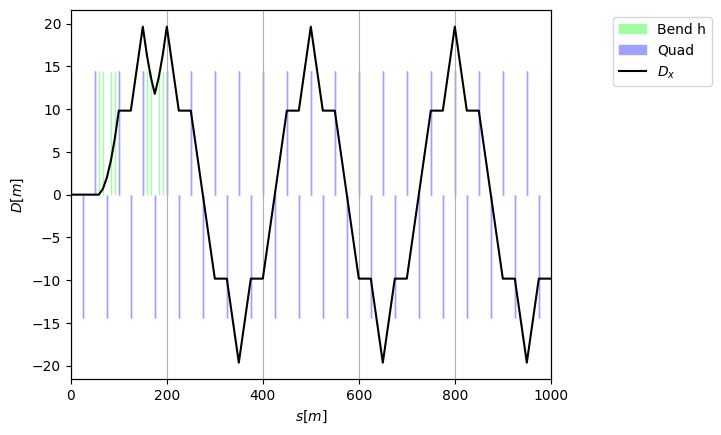

In [7]:
new_lattice = cell_straight+arc_cell+cell_straight+arc_cell+16*cell_straight
new_lattice.twiss4d(betx=my_twiss['betx'][0],
                    bety=my_twiss['bety'][0],
                    alfx=my_twiss['alfx'][0],
                    alfy=my_twiss['alfy'][0],
                    dx=0,
                    dpx=0).plot(yl='dx')

And now we can add others "FODO with dipoles" to sustain the dispersive wave.

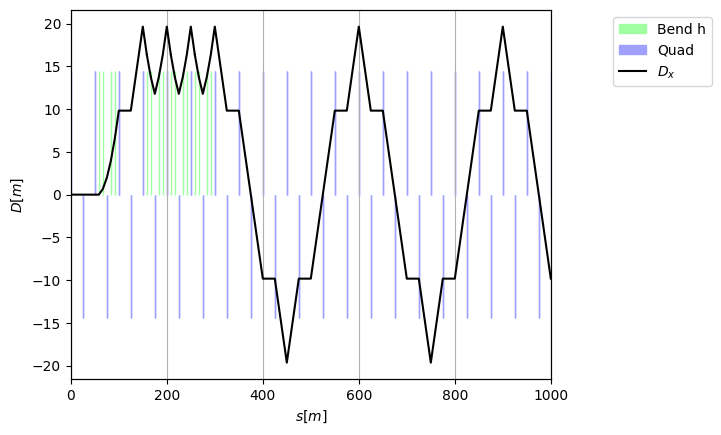

In [8]:
new_lattice = cell_straight+arc_cell+cell_straight+3*arc_cell+14*cell_straight
new_lattice.twiss4d(betx=my_twiss['betx'][0],
                    bety=my_twiss['bety'][0],
                    alfx=my_twiss['alfx'][0],
                    alfy=my_twiss['alfy'][0],
                    dx=0,
                    dpx=0).plot(yl='dx')

This initial consideration give rise to a series of topologies that we can consider for the dispersion suppressor. We need to pay attention that supressing the main bends **changes the reference orbit** so we need to verify the closure of the circular machine.

In addition it is quite "expensive" to remove dipoles in a high energy collider and it is not very convenient to impose a stringent phase advance of the arc of the machine. This schema has to be consider a starting point and in reality work (also) together with the quadrupole of the matching sections.

One can show that the following equation holds
\begin{equation}
\mu_{cell}=\frac{2 k+1}{2 m+n} \pi
\end{equation}
where $k\in\{0,1,\dots\}$, $m$ is the number of regular cells between the Interaction Point and the arc and $n$ is the number of missing-dipole cells. After having defined $m$ and $n$ we chose $\mu_{cell}$ accordingly.
We will do few examples.

# Missing bending with m=1 and n=1

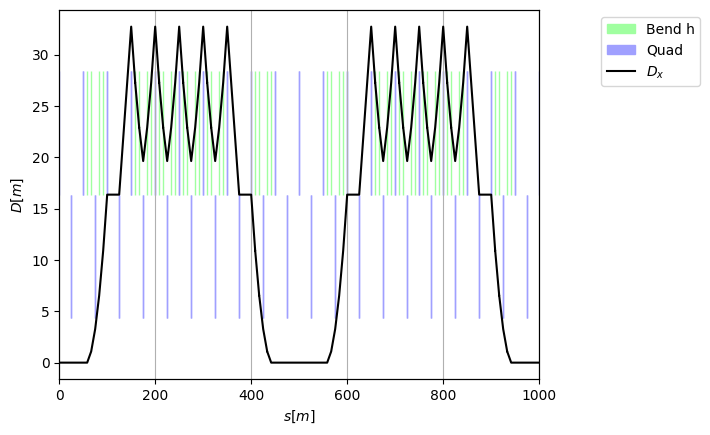

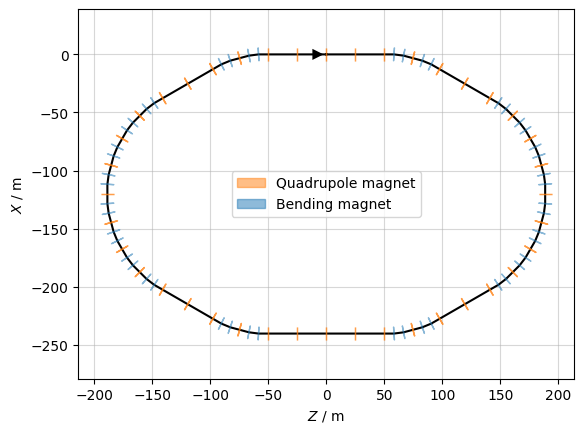

In [9]:
new_lattice_half = (cell_straight+
              arc_cell +
              cell_straight+
              4*arc_cell+
              cell_straight+
              arc_cell + 
              cell_straight) 
new_lattice = new_lattice_half - new_lattice_half
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*12) 
env['k1']=k1_60deg

new_lattice.twiss4d(betx=my_twiss['betx'][0],
                    bety=my_twiss['bety'][0],
                    alfx=my_twiss['alfx'][0],
                    alfy=my_twiss['alfy'][0],
                    dx=0,
                    dpx=0).plot(yl='dx')

new_lattice.survey().plot()

# Missing bending with m=1 and n=0
This is the pure racetrack configuration.

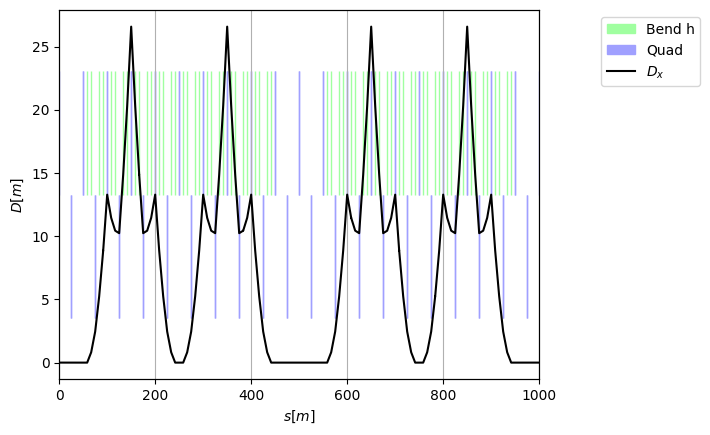

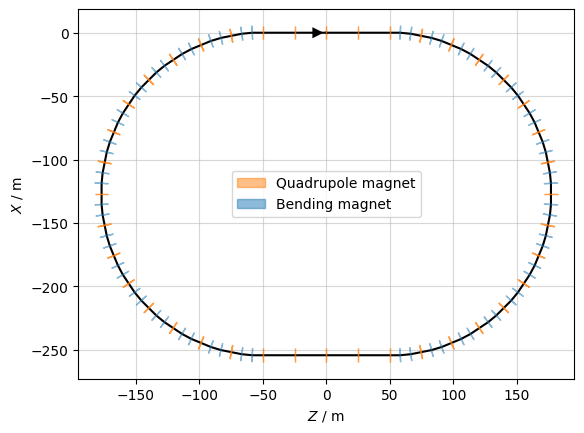

In [10]:
new_lattice_half = (cell_straight+
              8*arc_cell+
              cell_straight) 
new_lattice = new_lattice_half - new_lattice_half
env['k1'] = k1_90deg
my_twiss = ring.twiss4d()
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*16) 


new_lattice.twiss4d().plot(yl='dx')
new_lattice.survey().plot()

# Missing bending with m=0 and n=1
This is not possible since would require a $\pi$ phase advance.

# Missing bending with m=1 and n=2
This has two reasonable solution ($\pi/4$ and $3\pi/4$)

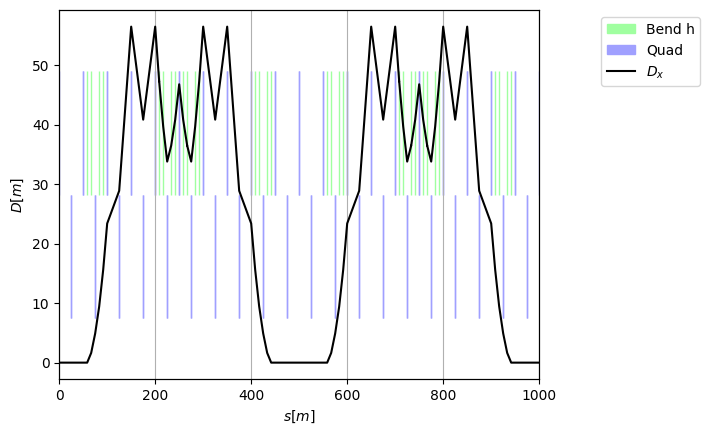

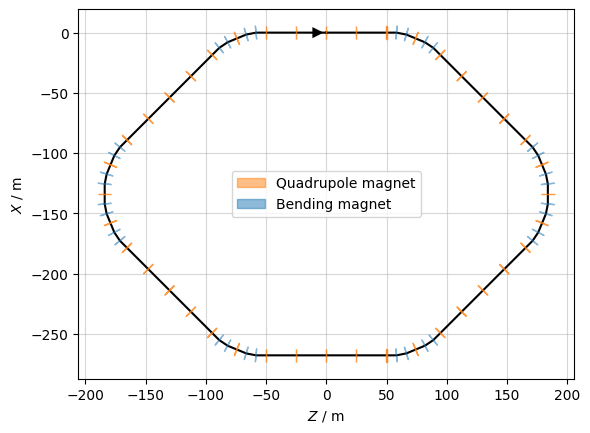

In [11]:
new_lattice_quarter = (cell_straight+
              arc_cell+
              2*cell_straight+
                arc_cell) 
new_lattice_half = new_lattice_quarter - new_lattice_quarter
new_lattice = new_lattice_half - new_lattice_half
env['k1'] = k1_45deg
my_twiss = ring.twiss4d()
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*8) 


new_lattice.twiss4d().plot(yl='dx')
new_lattice.survey().plot()

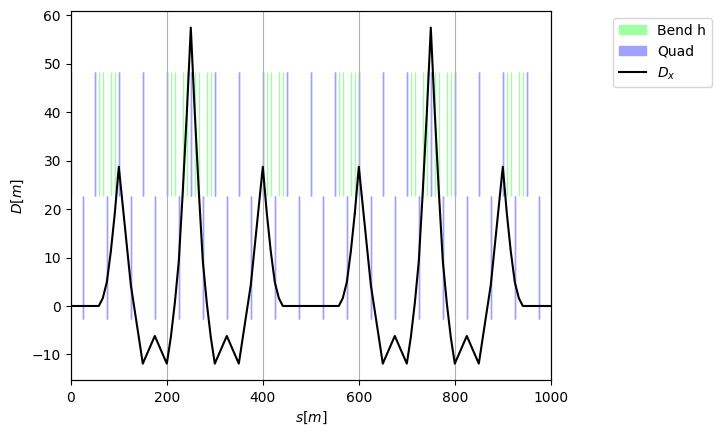

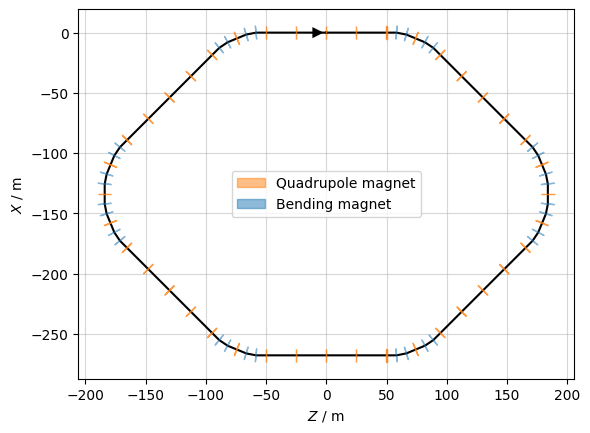

In [12]:
new_lattice_quarter = (cell_straight+
              arc_cell+
              2*cell_straight+
                arc_cell) 
new_lattice_half = new_lattice_quarter - new_lattice_quarter
new_lattice = new_lattice_half - new_lattice_half
env['k1'] = k1_135deg
my_twiss = ring.twiss4d()
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*8) 


new_lattice.twiss4d().plot(yl='dx')
new_lattice.survey().plot()

# An alternative approach: using the half-bending topology.
Using a similar approach, we can reduce the bending strength of the dipoles in some specific FODO cells to suppress dispersion.

\begin{equation}
\sin^2 \left(\frac{n \mu_{cell}}{2}\right)=\frac{r}{2}
\end{equation}
where $n$ is the number of cells where the dipole strenght is $r$-times weaker than the one in the regular arc cells ($r>1$) and, as usual, $\mu_{cell}$ is the cell phase advance.

## With n=2 and r=2
This implies $\mu=\pi/2$.

In [13]:
env.new('mb_half', xt.Multipole, knl = ['dipole_bending_angle/2'], hxl='dipole_bending_angle/2')

arc_half_cell_half_bending = env.new_line(components=[
    env.place('qf'),
    env.place('mb_half', at=cell_length/6, from_='qf'),
    env.place('mb_half', at=cell_length*2/6, from_='qf'),
    env.place('qd', at=cell_length/2, from_='qf'),
    ])

arc_cell_half_bending = arc_half_cell_half_bending - arc_half_cell_half_bending

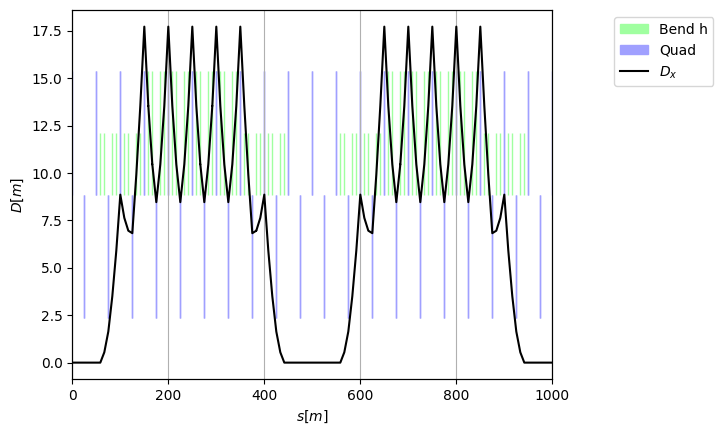

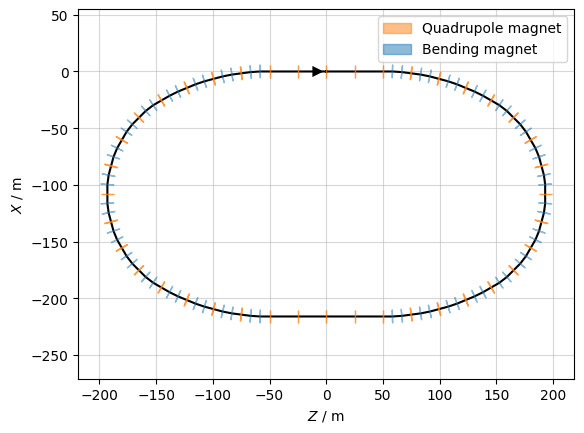

In [14]:
new_lattice_quarter = (cell_straight+
              2*arc_cell_half_bending+
              2*arc_cell) 
new_lattice_half = new_lattice_quarter - new_lattice_quarter
new_lattice = new_lattice_half - new_lattice_half
env['k1'] = k1_90deg
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*12) 

my_twiss = ring.twiss4d()


new_lattice.twiss4d().plot(yl='dx')
new_lattice.survey().plot()

### 3 half-bend cells and 60 deg phase advance.

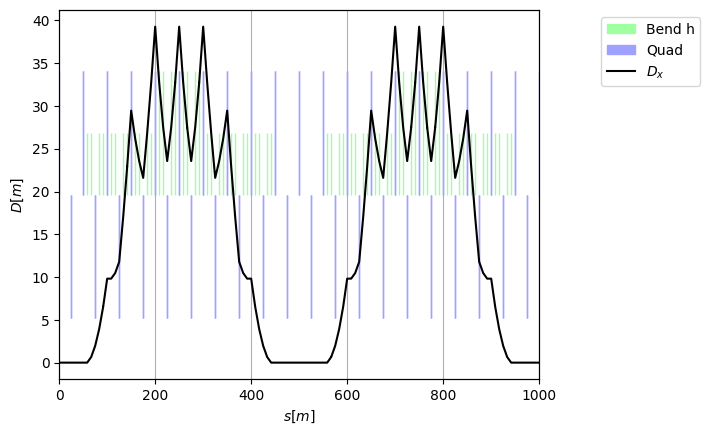

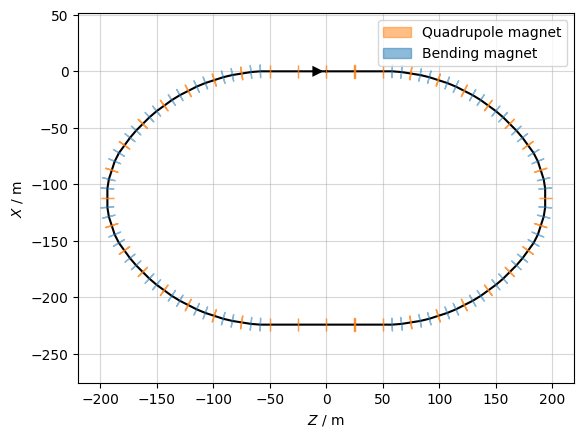

In [15]:
new_lattice_quarter = (cell_straight+
              3*arc_cell_half_bending+
             1*arc_cell) 
new_lattice_half = new_lattice_quarter - new_lattice_quarter
new_lattice = new_lattice_half - new_lattice_half
env['k1'] = k1_60deg
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*10) 

my_twiss = ring.twiss4d()

new_lattice.twiss4d().plot(yl='dx')
new_lattice.survey().plot()



# Phase advance in the arc equal to 2k$\pi$

Matching: model call n. 9               



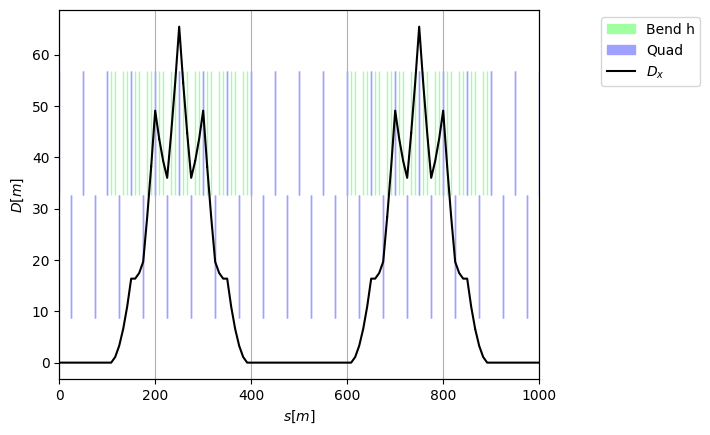

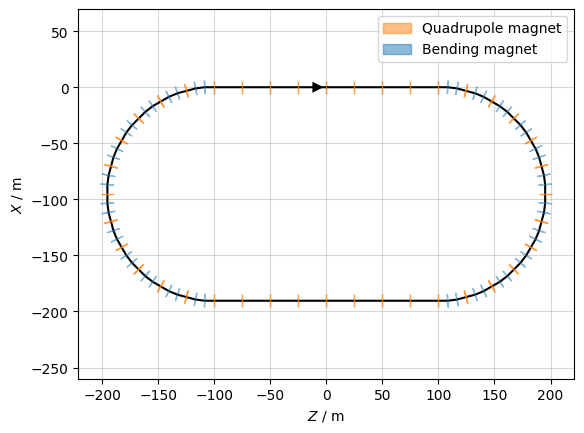

In [19]:
new_lattice_half = (2*cell_straight+
              6*arc_cell+
              2*cell_straight) 
new_lattice = new_lattice_half - new_lattice_half

opt = arc_cell.match(
    method='4d', # <- passed to twiss
    vary=[
        xt.Vary('k1', step=1e-8, tag='quad'),    ],
    targets = [
        xt.TargetSet(qx=1/6, tol=1e-6, tag='tune'),
    ])

my_twiss = ring.twiss4d()
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*12) 


new_lattice.twiss4d().plot(yl='dx')
new_lattice.survey().plot()

/Users/guidosterbini/miniforge3/lib/python3.12/site-packages/xtrack/linear_normal_form.py:185: RuntimeWarning: divide by zero encountered in scalar divide
  n1 = 1./np.sqrt(np.matmul(np.matmul(a1, S), b1))
/Users/guidosterbini/miniforge3/lib/python3.12/site-packages/xtrack/linear_normal_form.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  n2 = 1./np.sqrt(np.matmul(np.matmul(a2, S), b2))
/Users/guidosterbini/miniforge3/lib/python3.12/site-packages/xtrack/linear_normal_form.py:189: RuntimeWarning: invalid value encountered in multiply
  a1 *= n1
/Users/guidosterbini/miniforge3/lib/python3.12/site-packages/xtrack/linear_normal_form.py:190: RuntimeWarning: invalid value encountered in multiply
  a2 *= n2
/Users/guidosterbini/miniforge3/lib/python3.12/site-packages/xtrack/linear_normal_form.py:193: RuntimeWarning: invalid value encountered in multiply
  b1 *= n1
/Users/guidosterbini/miniforge3/lib/python3.12/site-packages/xtrack/linear_normal_form.py:194: RuntimeWarnin

Matching: model call n. 19               



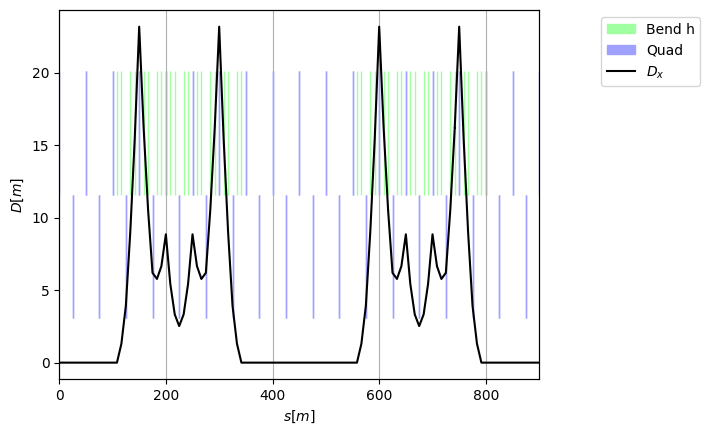

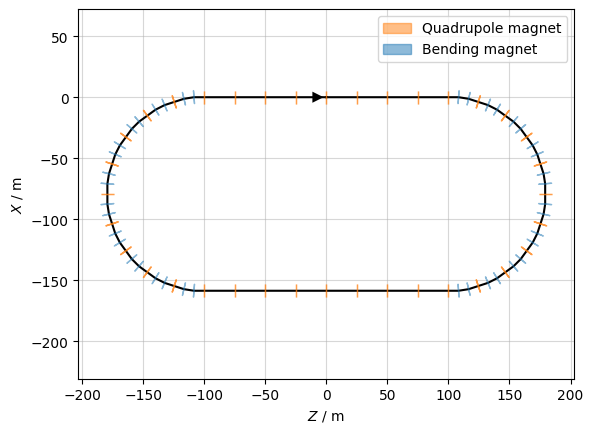

In [17]:
new_lattice_half = (2*cell_straight+
              5*arc_cell+
              2*cell_straight) 
new_lattice = new_lattice_half - new_lattice_half

opt = arc_cell.match(
    method='4d', # <- passed to twiss
    vary=[
        xt.Vary('k1', step=1e-8, tag='quad'),    ],
    targets = [
        xt.TargetSet(qx=2/5, tol=1e-6, tag='tune'),
    ])

my_twiss = ring.twiss4d()
env['dipole_bending_angle'] = 2*np.pi/(number_of_dipole_per_cell*10) 


new_lattice.twiss4d().plot(yl='dx')
new_lattice.survey().plot()